Import 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from numpy.random import randint, randn
from time import time
from scipy.stats import norm
from sklearn.utils import resample

Define Franke function

In [3]:
def FrankeFunction(x,y):
	term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
	term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
	term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
	term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
	return term1 + term2 + term3 + term4

Create design matrix for for two dimensions

In [4]:
def create_X(x, y, n):
    #n is the order of the polynomial, in this project it will be 5
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
    N = len(x)
    p = int((n+1)*(n+2)/2)  #Number of elements in beta, 
    X = np.ones((N, p))
    
    for i in range(1,n+1):
        q = int(i*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    
    return X

Define R2 score function

In [5]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

Define Mean Squared Error (MSE) function

In [6]:
def MSE(y_data,y_model):
    return np.sum((y_data-y_model)**2)/len(y_data)

Make design matrix

Normal distributed noise is added to the Franke-function 

In [7]:
n = 100 #size of x and y
N = 5 #polynomial degree
noise_factor = 0.01

x = np.random.uniform(0,1,n)
y = np.random.uniform(0,1,n)
noise = noise_factor*np.random.randn(100,1)
z = FrankeFunction(x,y) + noise

X = create_X(x, y, N)

DesignMatrix = pd.DataFrame(X)
#display(DesignMatrix)

Perform the Ordinary Least Square (OLS) method and print the MSE and R2 results

In [8]:
X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train

z_tilde = X_train @ beta
z_predict = X_test @ beta

print("Training R2")
print(R2(z_train,z_tilde))
print(' ')
print("Training MSE")
print(MSE(z_train,z_tilde))
print(' ')
print("Test R2")
print(R2(z_test,z_predict))
print(' ')
print("Test MSE")
print(MSE(z_test,z_predict))

Training R2
0.9991269436676102
 
Training MSE
0.008030125998357762
 
Test R2
0.9987160845360831
 
Test MSE
0.011805481259579326


Study the bias-variance trade-off by plotting the MSE for increasing model complexity (i.e. the number of polynomials)

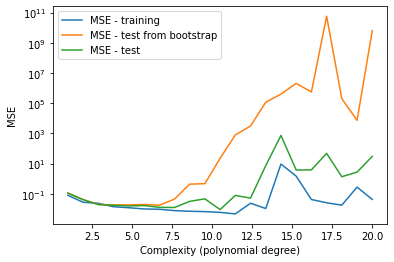

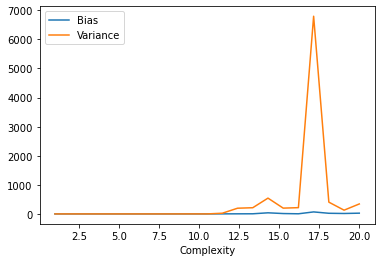

In [29]:
#np.random.seed(47309275)
max_degree = 20
n = 200
noise_factor = .1
n_bootstraps = 100

degree = np.linspace(1, max_degree, max_degree+1)
MSE_test = np.zeros(max_degree+1)
MSE_train = np.zeros(max_degree+1)
MSE_test_bootstrap = np.zeros(max_degree+1)

bias = np.zeros(max_degree+1)
variance = np.zeros(max_degree+1)
error = np.zeros(max_degree+1)

noise = noise_factor*np.random.randn(n)
x = np.random.uniform(0,1,n)
y = np.random.uniform(0,1,n)

z = FrankeFunction(x,y) + noise

for i in range(max_degree+1):
    N = i #polynomial degree
    X = create_X(x, y, N)
    
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)

    scaler = StandardScaler(with_mean = True, with_std = False)
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    #Perform regular OLS
    beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
    z_tilde = X_train @ beta
    z_predict = X_test @ beta
    MSE_train[i] = MSE(z_train,z_tilde)
    MSE_test[i] = MSE(z_test,z_predict)
    
    #Perform OLS with bootstrap resampling
    MSE_test_bootstrap_values = np.zeros(n_bootstraps)
    #z_predict_bootstrap = np.zeros(n_bootstraps)
    
    for j in range(n_bootstraps):
        X_train_resample, z_train_resample = resample(X_train, z_train, replace=True)
        beta = np.linalg.inv(X_train_resample.T @ X_train_resample) @ X_train_resample.T @ z_train_resample
        z_predict_bootstrap = X_test @ beta
        MSE_test_bootstrap_values[j] = MSE(z_test, z_predict_bootstrap) 
    
    MSE_test_bootstrap[i] = np.mean(MSE_test_bootstrap_values)
    
    bias[i] = np.mean( (z_test - np.mean(z_predict_bootstrap))**2 )
    variance[i] = np.mean( np.var(z_predict_bootstrap) )
    #error[i] = np.mean( np.mean((z_test - z_predict_bootstrap)**2) )
    
plt.figure()
plt.ylabel('MSE')
plt.xlabel('Complexity (polynomial degree)')
plt.plot(degree, MSE_train, label='MSE - training') 
plt.plot(degree, MSE_test_bootstrap, label='MSE - test from bootstrap') 
plt.plot(degree, MSE_test, label='MSE - test')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
plt.xlabel('Complexity')
plt.plot(degree, bias, label='Bias')
plt.plot(degree, variance, label='Variance')
#plt.plot(degree, error, label='Error')
plt.legend()
plt.show()

Implement k-fold cross validation

Implement Ridge Regression on Franke data

Implement Lasso regression on Franke data

Prepare real data for analysis

Apply all three regression methods to the real data with cross-validation as resampling